In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.mixture import GaussianMixture
from pathlib import Path
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set wd
os.chdir((Path.home()/"wdpath.txt").read_text().strip())

In [3]:
# load data
with open("processed-data/003-dat-dict.pkl",'rb') as f:
    dat_dict = pickle.load(f)

### Cluster PCs and PCAs with GMM

In [4]:
print(dat_dict['rDims']["PCA"]['scores'].shape)
print(dat_dict['rDims']["PCA"]['scores'].shape)

(17382, 50)
(17382, 50)


In [5]:
PC_df = (
    pd.DataFrame(dat_dict['rDims']["PCA"]['scores'][:,:3])
    .assign(tissue = dat_dict['colData'].SMTS.values)
)

NMF_df = (
    pd.DataFrame(dat_dict['rDims']["NMF"]['scores'][:,:3])
    .assign(tissue = dat_dict['colData'].SMTS.values)
)


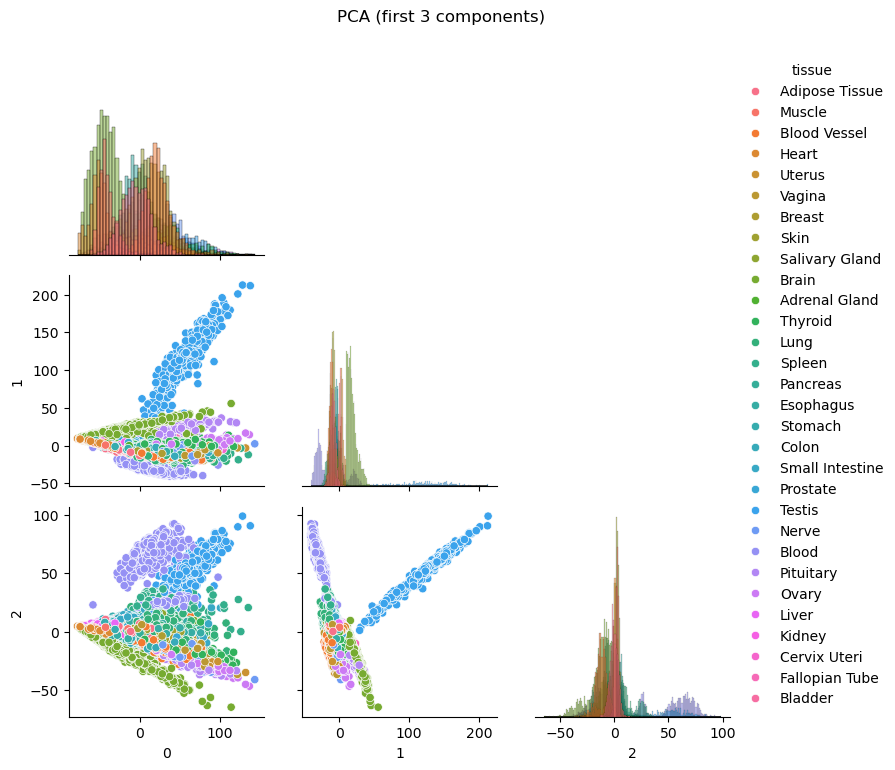

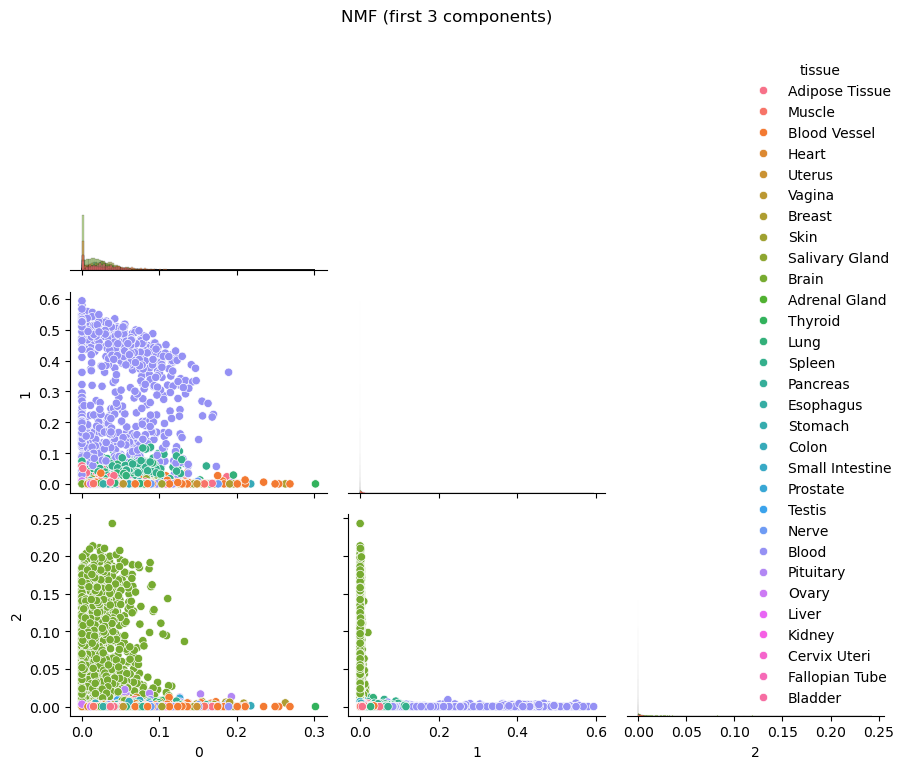

In [7]:
p1 = sns.PairGrid(PC_df, hue="tissue", corner=True, 
              vars=PC_df.columns[:3])
p1.map_lower(sns.scatterplot)
p1.map_diag(sns.histplot)
p1.map_upper(sns.scatterplot)
p1.add_legend()
p1.figure.suptitle("PCA (first 3 components)", y=1.02)

p2 = sns.PairGrid(NMF_df, hue="tissue", corner=True,
               vars=NMF_df.columns[:3])
p2.map_lower(sns.scatterplot)
p2.map_diag(sns.histplot)
p2.map_upper(sns.scatterplot)
p2.add_legend()
p2.figure.suptitle("NMF (first 3 components)", y=1.02)


plt.tight_layout()


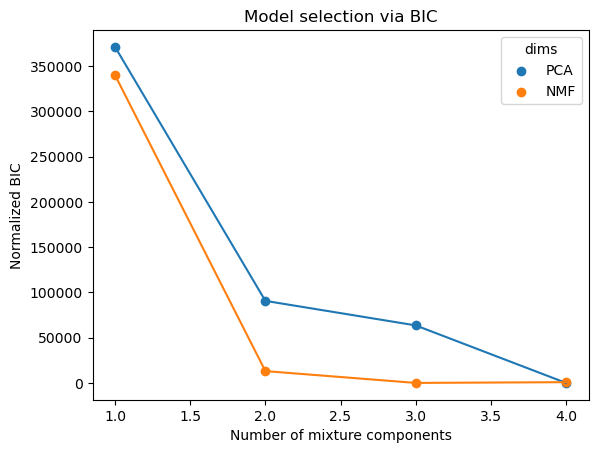

In [108]:
# find best component number
dims = ['PCA','NMF']
for dim in dims:
    res = []
    for i in range(1, 5):
        gmm = GaussianMixture(n_components=i, random_state=0)
        gmm.fit(dat_dict['rDims'][dim]['scores'])
        BIC = gmm.bic(dat_dict['rDims'][dim]['scores'])
        res.append({"i": i, "BIC": BIC})
        
    res = pd.DataFrame(res)
    res['BIC'] = res['BIC'] - res['BIC'].min()
    
    # res['BIC'] = res['BIC'] / res['BIC'].sum()
    
    plt.scatter(res.iloc[:,0], res.iloc[:,1], label = dim)
    # connect points with a line
    plt.plot(res['i'], res['BIC'])

plt.legend(title="dims")
plt.xlabel("Number of mixture components")
plt.ylabel("Normalized BIC")
plt.title("Model selection via BIC")
plt.show()



NMF components for two components have best BIC relative to PCA

#### Cluster on NMF Components

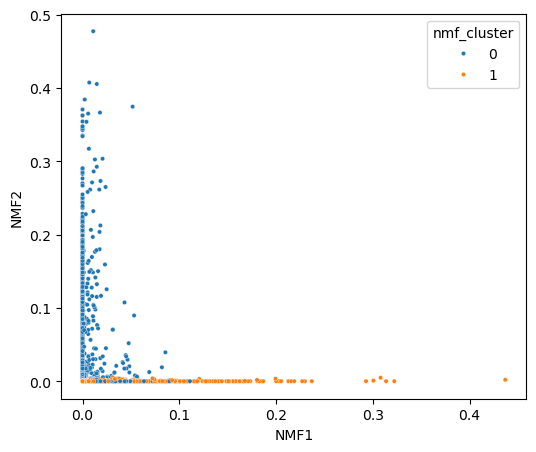

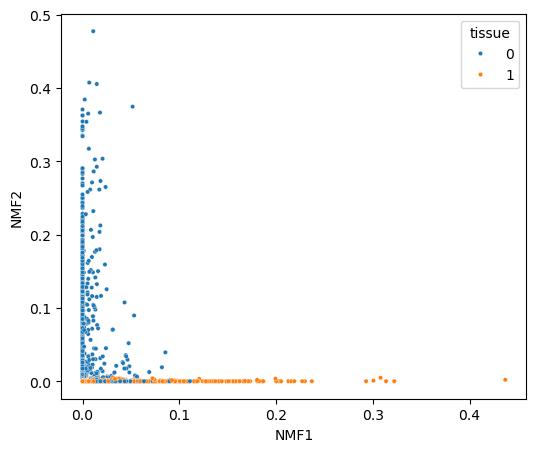

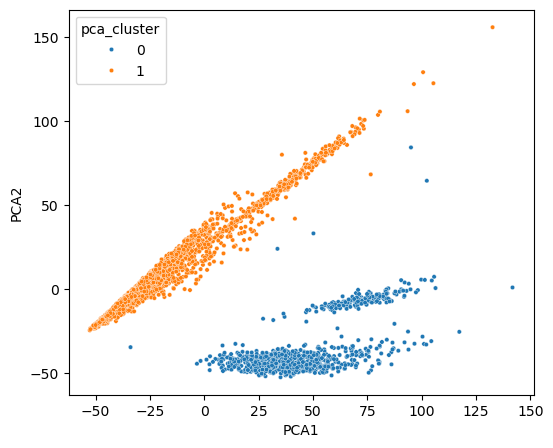

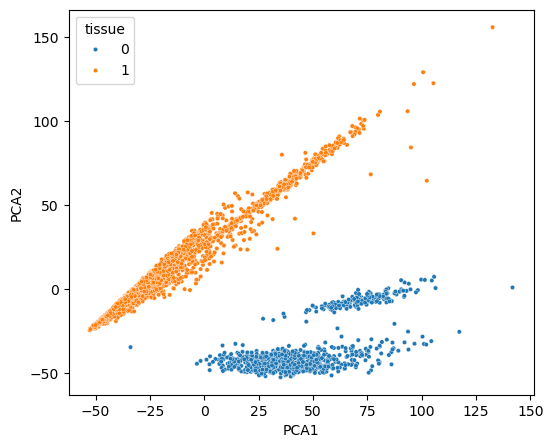

In [ ]:

# make model object
np.random.seed(1293)
NMF_gmm= GaussianMixture(n_components= 2,random_state=0) 
PCA_gmm= GaussianMixture(n_components= 2,random_state=0) 

# fit model
NMF_gmm.fit(dat_dict['rDims']['NMF']['scores'])
PCA_gmm.fit(dat_dict['rDims']['PCA']['scores'])

# predict clusters from data
NMF_clusters = NMF_gmm.predict(dat_dict['rDims']['NMF']['scores'])
PCA_clusters = PCA_gmm.predict(dat_dict['rDims']['PCA']['scores'])

nmf = pd.DataFrame(
    dat_dict['rDims']["NMF"]["scores"],
    columns=[f"NMF{i+1}" for i in range(dat_dict['rDims']['NMF']['scores'].shape[1])]
)

pca = pd.DataFrame(
    dat_dict['rDims']["PCA"]["scores"],
    columns=[f"PCA{i+1}" for i in range(dat_dict['rDims']['PCA']['scores'].shape[1])]
)

plot_df = pd.concat([nmf, pca], axis=1).assign(
    nmf_cluster=NMF_clusters,
    pca_cluster=PCA_clusters,
    tissue = (dat_dict['colData'].SMTS.values=="Brain").astype(int)
)


plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="NMF1", y="NMF2",
    hue="nmf_cluster",
    s=10
)
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="NMF1", y="NMF2",
    hue="tissue",
    s=10
)
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="PCA1", y="PCA2",
    hue="pca_cluster",
    s=10
)
plt.show()


plt.figure(figsize=(6,5))
sns.scatterplot(
    data=plot_df,
    x="PCA1", y="PCA2",
    hue="tissue",
    s=10
)
plt.show()



In [1]:
from sklearn.metrics import classification_report

y_true = (dat_dict['colData']['SMTS'].values == "Brain").astype(int)

print("\\\\ NMF GMM classification Report \\\\\n",classification_report(y_true, NMF_clusters, zero_division=0))
print("\\\\ PCA GMM classification Report \\\\\n",classification_report(y_true, PCA_clusters, zero_division=0))

NameError: name 'dat_dict' is not defined

Classification on NMF performs pefectly